## Segment anything model [SAM](https://segment-anything.com/) by meta


Applied to Microscopy images - Prepared by Utkarsh Pratiush
- https://github.com/utkarshp1161

Data :
- [Sheryl Sanchez](https://cmp.utk.edu/sheryl-sanchez/)

On cpu it takes 1024*1024 image > 3 minutes.
To get quicker results try on a gpu runtime on colab.

In [ ]:
# Install segment-anything and other dependencies
!pip install segment-anything
!pip install torch torchvision
!pip install matplotlib

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from PIL import Image
import requests
import os

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Specify the model type and checkpoint URL
model_type = "vit_b"  # Options: 'vit_b', 'vit_l', 'vit_h'
checkpoint_url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
checkpoint_path = "sam_vit_b_01ec64.pth"

if not os.path.exists(checkpoint_path):
    print("Downloading SAM model checkpoint...")
    response = requests.get(checkpoint_url)
    with open(checkpoint_path, "wb") as f:
        f.write(response.content)
    print("Download complete.")
else:
    print("SAM model checkpoint already exists.")

Download complete.


In [ ]:
# Load the SAM model
sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
sam.to(device=device)
# Initialize the automatic mask generator
mask_generator = SamAutomaticMaskGenerator(sam)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [ ]:
!gdown --id 1CbSBI5q-5xL77_VT30rzAKJbxOiH8du5

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1CbSBI5q-5xL77_VT30rzAKJbxOiH8du5
To: /content/sheryl_img.png
100% 923k/923k [00:00<00:00, 125MB/s]


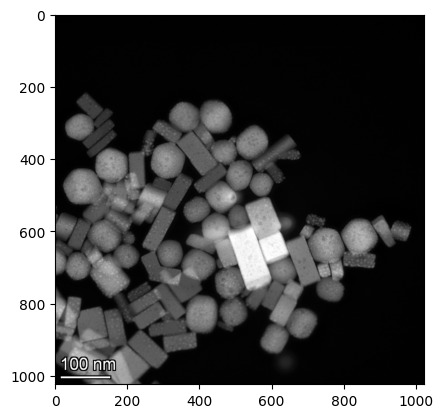

In [ ]:
img_pil = Image.open("sheryl_img.png").convert("RGB")
plt.imshow(img_pil)

In [ ]:
img_np = np.array(img_pil)
print("Generating masks...")
masks = mask_generator.generate(img_np)
print(f"Number of masks generated: {len(masks)}")

Generating masks...
Number of masks generated: 110


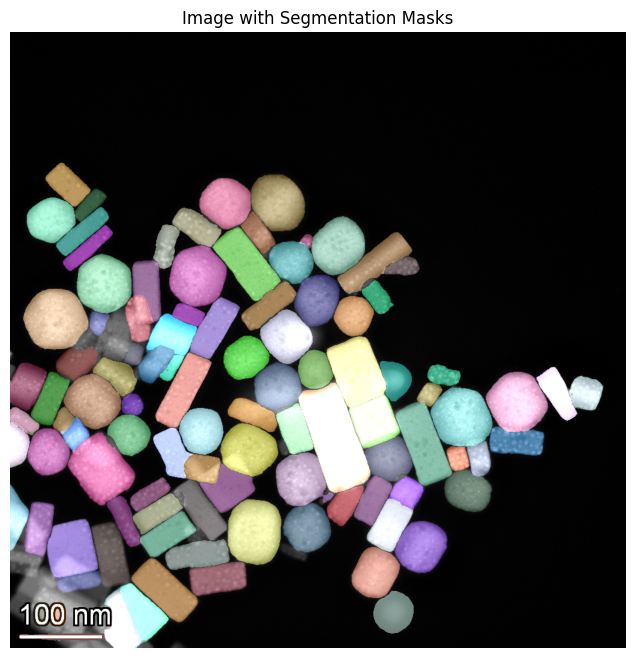

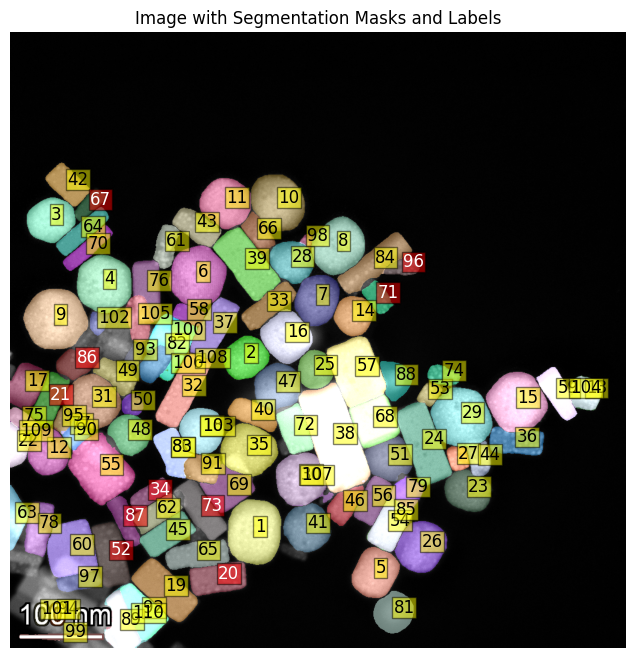

In [ ]:
import cv2

visual_image = img_np.copy()

# Iterate through each mask and overlay it with a unique color
for idx, mask in enumerate(masks, 1):  # Start counting from 1
    segmentation = mask["segmentation"]
    color = np.random.randint(0, 255, (3,), dtype=np.uint8)
    # Create a colored mask
    colored_mask = np.zeros_like(visual_image)
    colored_mask[segmentation] = color
    visual_image = cv2.addWeighted(visual_image, 1.0, colored_mask, 0.5, 0)

centroids = []
for idx, mask in enumerate(masks, 1):
    segmentation = mask["segmentation"]
    coords = np.column_stack(np.where(segmentation))
    if coords.size == 0:  # Skip if mask is empty
        continue
    # Compute the centroid
    centroid = coords.mean(axis=0)
    centroids.append((centroid[1], centroid[0], idx))  # (x, y, label)

# Display the image with colored masks
plt.figure(figsize=(8, 8))
plt.imshow(visual_image)
plt.axis("off")
plt.title("Image with Segmentation Masks")
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(visual_image)
ax = plt.gca()

for x, y, label in centroids:
    # Choose a contrasting color for the text
    text_color = "white" if np.mean(visual_image[int(y), int(x)]) < 128 else "black"
    ax.text(
        x,
        y,
        str(label),
        color=text_color,
        fontsize=12,
        bbox=dict(
            facecolor="red" if text_color == "white" else "yellow", alpha=0.5, pad=1
        ),
    )

plt.axis("off")
plt.title("Image with Segmentation Masks and Labels")
plt.show()

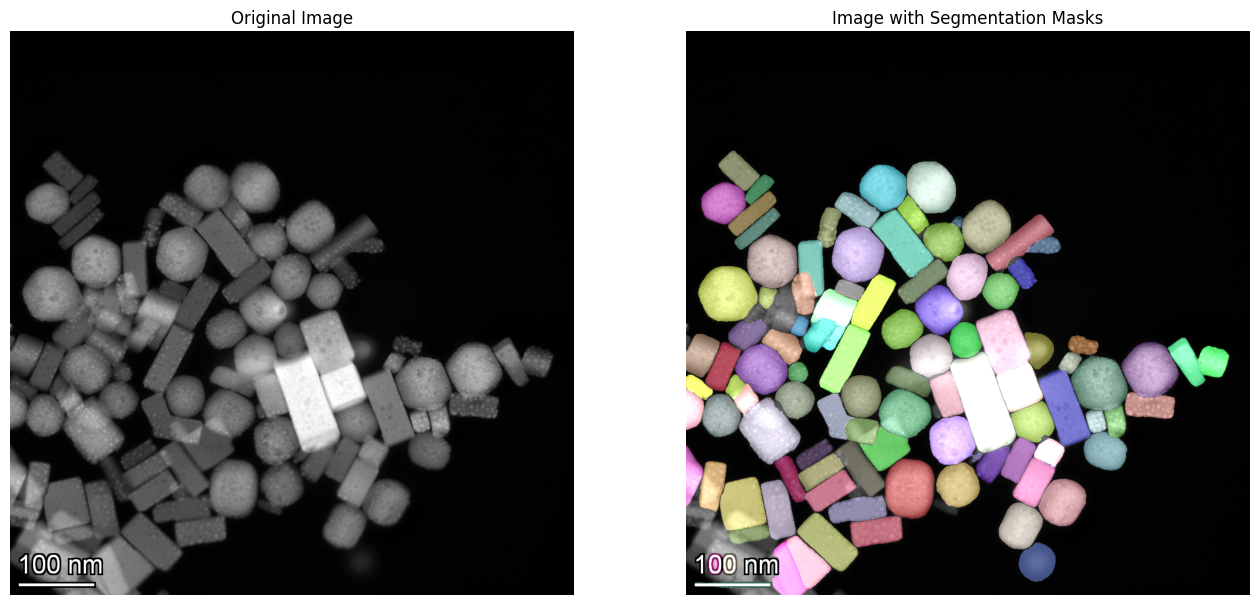

In [ ]:
# plot original and segmented together
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(visual_image)
plt.title("Image with Segmentation Masks")
plt.axis("off")

plt.show()